# Standard Penalized splines vs FastNCVPenalizedSpline

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import perf_counter
from typing import Dict, Callable

from utils.evaluation import make_splits
from utils.synthetic_series import SyntheticSeries
from utils.search import cv_select_param, mse
from utils.models.penalized_spline import PenalizedSplineRegressor
from utils.optimized_model import FastNCVPenalizedSpline
from utils.models.base import Regressor

from utils.plotting import plot_comparison_results, plot_time_comparison

%load_ext autoreload
%autoreload 2

print("Imports successful")

Imports successful


/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/plotting.py:617: SyntaxWarning: invalid escape sequence '\l'
  label=f'Standard ($\lambda$={lam_std:.4f})', zorder=2)
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/plotting.py:622: SyntaxWarning: invalid escape sequence '\l'
  label=f'FastNCV ($\lambda$={lam_fast:.4f})', zorder=3)
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/plotting.py:655: SyntaxWarning: invalid escape sequence '\l'
  ax1.set_xlabel('Lambda ($\lambda$)', fontsize=9)


## Common parameters and synthetic data

In [2]:
np.random.seed(123)

n = 1000
f_id = "local_bump"
error_model="arima"
error_params = {
    "p": 1,          
    "d": 0,          
    "q": 0,          
    "ar": [0.8],    
    "ma": [0.7],
    "sigma": 0.3, 
}

buffer_l = 10
lambda_grid = np.logspace(0, 4, 50)  
n_knots = 30
degree = 3

seed_train = 123
seed_test = 456

print(f"n_samples = {n}")
print(f"buffer_l = {buffer_l}")
print(f"n_knots = {n_knots}, degree = {degree}")
print(f"lambda_grid length = {len(lambda_grid)}")

n_samples = 1000
buffer_l = 10
n_knots = 30, degree = 3
lambda_grid length = 50


In [3]:
train_sim = SyntheticSeries.generate(
    n=n,
    f_id=f_id,
    error_model=error_model,
    params=error_params,
    seed=seed_train,
)
test_sim = SyntheticSeries.generate(
    n=n,
    f_id=f_id,
    error_model=error_model,
    params=error_params,
    seed=seed_test,
)

x_train, y_train = train_sim.x, train_sim.y
x_test, y_test = test_sim.x, test_sim.y

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

x_train shape: (1000,), y_train shape: (1000,)
x_test shape: (1000,), y_test shape: (1000,)


## PenalizedSplineRegressor with leave 2l+1 out cv

In [ ]:
print("\n" + "="*60)
print("METHOD 1: Standard Penalized splines with leave 2l+1 cv")
print("="*60)

model_name = "spline"
cv_name = "leave_2l_plus_1_out"

def spline_factory() -> Regressor:
    return PenalizedSplineRegressor(param_value=1.0, n_knots=30, degree=3)

MODEL_FACTORIES: Dict[str, Callable[[], Regressor]] = {
    "spline": spline_factory
}

if model_name not in MODEL_FACTORIES:
    raise KeyError(f"Unknown model '{model_name}'.")
model_factory = MODEL_FACTORIES[model_name]

print(f"Setting:")
print(f"  Model: {model_name}")
print(f"  CV Scheme: {cv_name} (l={buffer_l})")
print(f"  Lambda grid size: {len(lambda_grid)}")
print("-" * 60)

t0 = perf_counter()

splits = make_splits(cv_name, len(x_train), seed=seed_train, l=buffer_l)

cv_scores_run_exp = []
for i, lam in enumerate(lambda_grid):
    cv_res = cv_select_param(
        model_factory=spline_factory,
        x=x_train,
        y=y_train,
        splits=splits,
        grid=[lam], 
        metric=mse,
    )
    cv_scores_run_exp.append(cv_res.best_score)
    if (i + 1) % 5 == 0:
        print(f"  [{i+1}/{len(lambda_grid)}] lambda={lam:.6f}, CV_error={cv_res.best_score:.6f}")
        
time_standard_cv = perf_counter() - t0

final_model = model_factory()
final_model.set_param(lambda_grid[np.argmin(cv_scores_run_exp)])
final_model.fit(x_train, y_train)
y_pred_test = final_model.predict(x_test)
test_err = mse(y_test, y_pred_test)

lambda_selected_run_exp = lambda_grid[np.argmin(cv_scores_run_exp)]
cv_error_run_exp = np.min(cv_scores_run_exp)
test_error_run_exp = test_err
time_run_exp=time_standard_cv

print(f"\nLambda selected: {lambda_selected_run_exp:.6f}")
print(f"CV error (leave 2l+1 out): {cv_error_run_exp:.6f}")
print(f"Test error: {test_error_run_exp:.6f}")
print(f"Wall time: {time_run_exp:.4f} s")


METHOD 1: Standard Penalized splines with leave 2l+1 cv
Setting:
  Model: spline
  CV Scheme: leave_2l_plus_1_out (l=10)
  Lambda grid size: 50
------------------------------------------------------------
  [5/50] lambda=2.120951, CV_error=0.773013
  [10/50] lambda=5.428675, CV_error=0.749515
  [15/50] lambda=13.894955, CV_error=0.739014
  [20/50] lambda=35.564803, CV_error=0.738803
  [25/50] lambda=91.029818, CV_error=0.766628
  [30/50] lambda=232.995181, CV_error=0.852757
  [35/50] lambda=596.362332, CV_error=0.990560
  [40/50] lambda=1526.417967, CV_error=1.131266
  [45/50] lambda=3906.939937, CV_error=1.262566
  [50/50] lambda=10000.000000, CV_error=1.405389

Lambda selected: 24.420531
CV error (leave 2l+1 out): 0.737063
Test error: 0.801679
Wall time: 18.6279 s


## FastNCVPenalizedSpline

In [ ]:
print("\n" + "="*60)
print("METHOD 2: FastNCVPenalizedSpline")
print("="*60)

fast_model = FastNCVPenalizedSpline(
    n_knots=n_knots,
    degree=degree,
    penalty_order=2
)

t0 = perf_counter()

fast_model.fit(x_train, y_train)


print(f" NCV scores for {len(lambda_grid)} values of lambda...")
ncv_scores = []


for i, lam in enumerate(lambda_grid):
    score = fast_model.compute_ncv_score(lam, l_buffer=buffer_l)
    ncv_scores.append(score)
    if (i + 1) % 5 == 0:
        print(f"  [{i+1}/{len(lambda_grid)}] lambda={lam:.6f}, NCV_error={score:.6f}")

time_fast_ncv = perf_counter() - t0

best_idx_fast = np.argmin(ncv_scores)
lambda_selected_fast = lambda_grid[best_idx_fast]
cv_error_fast = ncv_scores[best_idx_fast]


fast_model._fit_for_lambda(lambda_selected_fast)
y_pred_test_fast = fast_model.X[:len(x_test)] @ fast_model.coef_  


fast_model_test = FastNCVPenalizedSpline(n_knots=n_knots, degree=degree, penalty_order=2)
fast_model_test.fit(x_test, y_test)  
fast_model_test._fit_for_lambda(lambda_selected_fast)

fast_model_pred = FastNCVPenalizedSpline(n_knots=n_knots, degree=degree, penalty_order=2)
fast_model_pred.fit(x_train, y_train)
fast_model_pred._fit_for_lambda(lambda_selected_fast)
X_test_basis = fast_model_pred.spline_trans.transform(x_test.reshape(-1, 1))
y_pred_test_fast = X_test_basis @ fast_model_pred.coef_
test_error_fast = np.mean((y_test - y_pred_test_fast)**2)

print(f"\nFastNCVPenalizedSpline results:")
print(f"Lambda selected: {lambda_selected_fast:.6f}")
print(f"NCV error: {cv_error_fast:.6f}")
print(f"Test error: {test_error_fast:.6f}")
print(f"Wall time: {time_fast_ncv:.4f} s")


METHOD 2: FastNCVPenalizedSpline
 NCV scores for 50 values of lambda...
  [5/50] lambda=2.120951, NCV_error=0.773247


/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: divide by zero encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: overflow encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: invalid value encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:76: RuntimeWarning: divide by zero encountered in matmul
  XtX = self.X.T @ self.X
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:76: Run

  [10/50] lambda=5.428675, NCV_error=0.749491
  [15/50] lambda=13.894955, NCV_error=0.738870
  [20/50] lambda=35.564803, NCV_error=0.738596
  [25/50] lambda=91.029818, NCV_error=0.766538
  [30/50] lambda=232.995181, NCV_error=0.852926
  [35/50] lambda=596.362332, NCV_error=0.990708
  [40/50] lambda=1526.417967, NCV_error=1.131134
  [45/50] lambda=3906.939937, NCV_error=1.262370
  [50/50] lambda=10000.000000, NCV_error=1.405395

FastNCVPenalizedSpline results:
Lambda selected: 24.420531
NCV error: 0.736870
Test error: 0.801679
Wall time: 1.7795 s


/var/folders/x8/sgtd_61s4qq82nnph19grmnm0000gn/T/ipykernel_94152/155281069.py:36: RuntimeWarning: divide by zero encountered in matmul
  y_pred_test_fast = fast_model.X[:len(x_test)] @ fast_model.coef_
/var/folders/x8/sgtd_61s4qq82nnph19grmnm0000gn/T/ipykernel_94152/155281069.py:36: RuntimeWarning: overflow encountered in matmul
  y_pred_test_fast = fast_model.X[:len(x_test)] @ fast_model.coef_
/var/folders/x8/sgtd_61s4qq82nnph19grmnm0000gn/T/ipykernel_94152/155281069.py:36: RuntimeWarning: invalid value encountered in matmul
  y_pred_test_fast = fast_model.X[:len(x_test)] @ fast_model.coef_
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: divide by zero encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: overflow encountered in matmu

## Plots

/var/folders/x8/sgtd_61s4qq82nnph19grmnm0000gn/T/ipykernel_94152/1989878362.py:10: RuntimeWarning: divide by zero encountered in matmul
  y_pred_train_fast = model_fast_already_fitted.X @ model_fast_already_fitted.coef_
/var/folders/x8/sgtd_61s4qq82nnph19grmnm0000gn/T/ipykernel_94152/1989878362.py:10: RuntimeWarning: overflow encountered in matmul
  y_pred_train_fast = model_fast_already_fitted.X @ model_fast_already_fitted.coef_
/var/folders/x8/sgtd_61s4qq82nnph19grmnm0000gn/T/ipykernel_94152/1989878362.py:10: RuntimeWarning: invalid value encountered in matmul
  y_pred_train_fast = model_fast_already_fitted.X @ model_fast_already_fitted.coef_
/var/folders/x8/sgtd_61s4qq82nnph19grmnm0000gn/T/ipykernel_94152/1989878362.py:11: RuntimeWarning: divide by zero encountered in matmul
  y_pred_test_fast = X_test_basis @ model_fast_already_fitted.coef_
/var/folders/x8/sgtd_61s4qq82nnph19grmnm0000gn/T/ipykernel_94152/1989878362.py:11: RuntimeWarning: overflow encountered in matmul
  y_pred_test

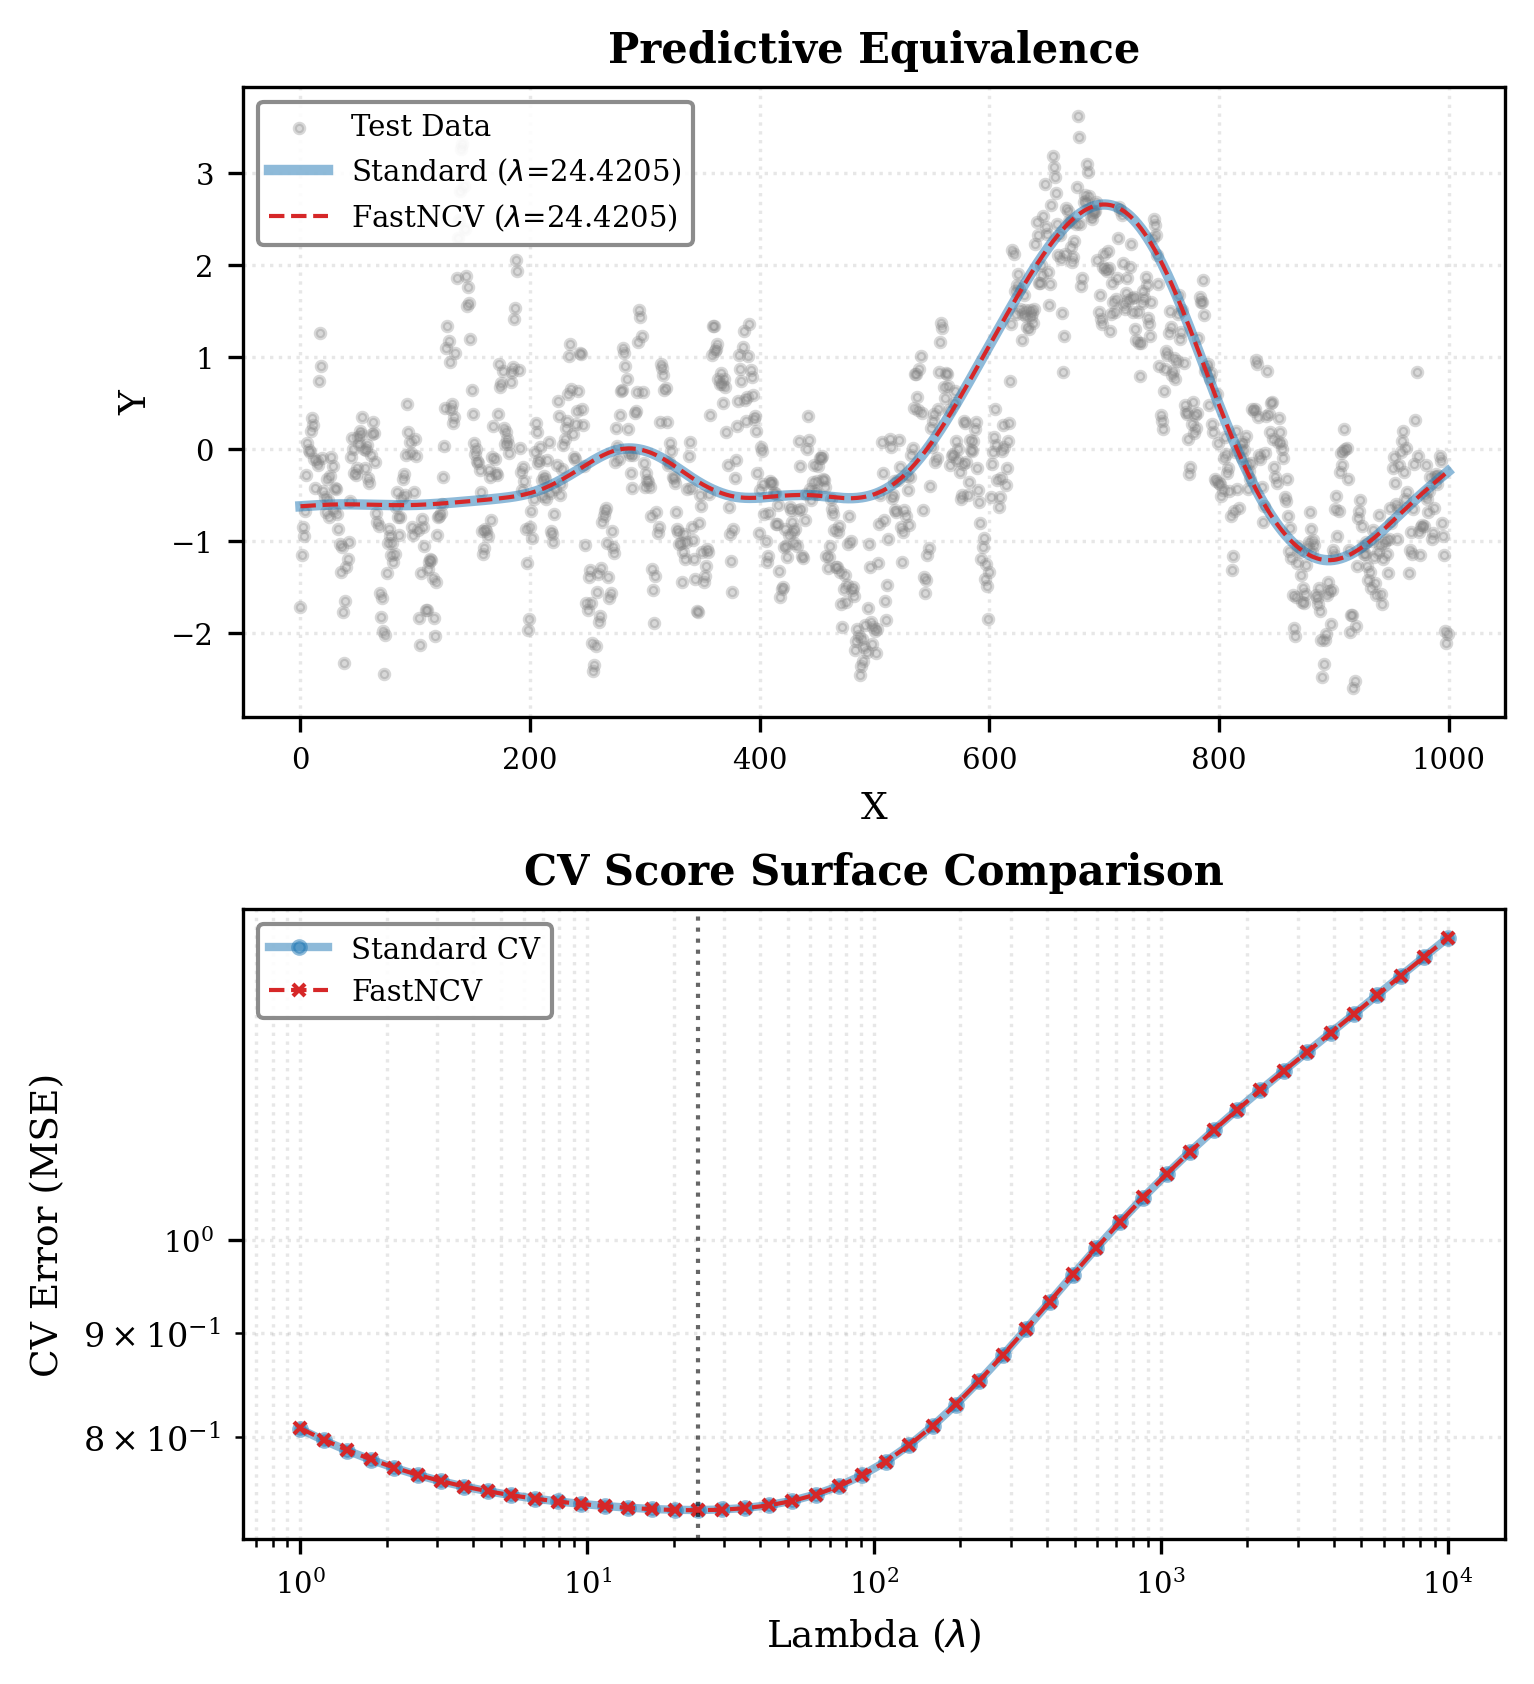

In [6]:
def spline_factory_run_exp():
    return PenalizedSplineRegressor(param_value=lambda_selected_run_exp, n_knots=n_knots, degree=degree)

model_run_exp = spline_factory_run_exp()
model_run_exp.fit(x_train, y_train)
y_pred_train_run_exp = model_run_exp.predict(x_train)
y_pred_test_run_exp = model_run_exp.predict(x_test)

model_fast_already_fitted = fast_model_pred
y_pred_train_fast = model_fast_already_fitted.X @ model_fast_already_fitted.coef_
y_pred_test_fast = X_test_basis @ model_fast_already_fitted.coef_


plot_comparison_results(x_test, y_test, y_pred_test_run_exp, y_pred_test_fast, lambda_selected_run_exp, lambda_selected_fast, lambda_grid, cv_scores_run_exp, ncv_scores)

## Speedup comparison when increasing n

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger().setLevel(logging.ERROR)

In [ ]:
f_id = "smooth_trend"
error_model = "arima"
error_params = {
    "p": 1,          
    "d": 0,          
    "q": 0,          
    "ar": [0.8],    
    "ma": [0.8],
    "sigma": 0.15, 
}

buffer_l = 10
lambda_grid = np.logspace(0, 4, 30)  
n_knots = 30
degree = 3

seed_train_base = 123
seed_test_base = 456

n_values = [100, 500, 1000, 2000, 3000, 5000, 10000] 

results_benchmark = []

print("="*80)
print(f"BENCHMARK STARTING: Testing n values: {n_values}")
print(f"Parameters: buffer_l={buffer_l}, knots={n_knots}, lambda_grid_len={len(lambda_grid)}")
print("="*80)


for n in n_values:
    print(f"\n>>> RUNNING SIMULATION FOR n = {n} <<<")
    
    seed_train = seed_train_base + n  
    seed_test = seed_test_base + n
    
    train_sim = SyntheticSeries.generate(
        n=n,
        f_id=f_id,
        error_model=error_model,
        params=error_params,
        seed=seed_train,
    )
    test_sim = SyntheticSeries.generate(
        n=n,
        f_id=f_id,
        error_model=error_model,
        params=error_params,
        seed=seed_test,
    )

    x_train, y_train = train_sim.x, train_sim.y
    x_test, y_test = test_sim.x, test_sim.y

    print(f"Data generated. Train shape: {x_train.shape}")


    print("\n" + "="*60)
    print(f"METHOD 1 (n={n}): Standard Penalized splines with leave 2l+1 cv")
    print("="*60)

    model_name = "spline"
    cv_name = "leave_2l_plus_1_out"

    def spline_factory() -> Regressor:
        return PenalizedSplineRegressor(param_value=1.0, n_knots=30, degree=3)

    MODEL_FACTORIES: Dict[str, Callable[[], Regressor]] = {
        "spline": spline_factory
    }

    if model_name not in MODEL_FACTORIES:
        raise KeyError(f"Unknown model '{model_name}'.")
    model_factory = MODEL_FACTORIES[model_name]

    t0 = perf_counter()

    splits = make_splits(cv_name, len(x_train), seed=seed_train, l=buffer_l)

    cv_res = cv_select_param(
        model_factory=model_factory,
        x=x_train,
        y=y_train,
        splits=splits,
        grid=lambda_grid,
        metric=mse,
    )

    time_standard_cv = perf_counter() - t0

    print(f"Done. Time: {time_standard_cv:.4f} s")
    
    final_model = model_factory()
    final_model.set_param(cv_res.best_param)
    final_model.fit(x_train, y_train)
    y_pred_test = final_model.predict(x_test)
    test_err_std = mse(y_test, y_pred_test)


    print("\n" + "="*60)
    print(f"METHOD 2 (n={n}): FastNCVPenalizedSpline")
    print("="*60)

    fast_model = FastNCVPenalizedSpline(
        n_knots=n_knots,
        degree=degree,
        penalty_order=2
    )

    t0 = perf_counter()

    fast_model.fit(x_train, y_train)

    print(f" NCV scores for {len(lambda_grid)} values of lambda...")
    ncv_scores = []

    for i, lam in enumerate(lambda_grid):
        score = fast_model.compute_ncv_score(lam, l_buffer=buffer_l)
        ncv_scores.append(score)
        
    time_fast_ncv = perf_counter() - t0

    print(f"Done. Time: {time_fast_ncv:.4f} s")

    best_idx_fast = np.argmin(ncv_scores)
    lambda_selected_fast = lambda_grid[best_idx_fast]
    cv_error_fast = ncv_scores[best_idx_fast]

    fast_model_pred = FastNCVPenalizedSpline(n_knots=n_knots, degree=degree, penalty_order=2)
    fast_model_pred.fit(x_train, y_train)
    fast_model_pred._fit_for_lambda(lambda_selected_fast)
    X_test_basis = fast_model_pred.spline_trans.transform(x_test.reshape(-1, 1))
    y_pred_test_fast = X_test_basis @ fast_model_pred.coef_
    test_error_fast = np.mean((y_test - y_pred_test_fast)**2)

    results_benchmark.append({
        "n": n,
        "time_std": time_standard_cv,
        "time_fast": time_fast_ncv,
        "speedup": time_standard_cv / time_fast_ncv if time_fast_ncv > 0 else 0,
        "lambda_std": cv_res.best_param,
        "lambda_fast": lambda_selected_fast,
        "mse_test_std": test_err_std,
        "mse_test_fast": test_error_fast
    })
    
    print("-" * 40)
    print(f"SUMMARY n={n}:")
    print(f"  Time Std:  {time_standard_cv:.4f} s")
    print(f"  Time Fast: {time_fast_ncv:.4f} s")
    print(f"  Speedup:   {time_standard_cv / time_fast_ncv:.2f}x")
    print("-" * 40)

df_results = pd.DataFrame(results_benchmark)
print("\nBENCHMARK COMPLETE.")
print(df_results)

BENCHMARK STARTING: Testing n values: [100, 500, 1000, 2000, 3000, 5000, 10000]
Parameters: buffer_l=10, knots=30, lambda_grid_len=30

>>> RUNNING SIMULATION FOR n = 100 <<<
Data generated. Train shape: (100,)

METHOD 1 (n=100): Standard Penalized splines with leave 2l+1 cv
Done. Time: 0.7554 s

METHOD 2 (n=100): FastNCVPenalizedSpline
 NCV scores for 30 values of lambda...
Done. Time: 0.1035 s
----------------------------------------
SUMMARY n=100:
  Time Std:  0.7554 s
  Time Fast: 0.1035 s
  Speedup:   7.30x
----------------------------------------

>>> RUNNING SIMULATION FOR n = 500 <<<
Data generated. Train shape: (500,)

METHOD 1 (n=500): Standard Penalized splines with leave 2l+1 cv


/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: divide by zero encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: overflow encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: invalid value encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:76: RuntimeWarning: divide by zero encountered in matmul
  XtX = self.X.T @ self.X
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:76: Run

Done. Time: 4.5768 s

METHOD 2 (n=500): FastNCVPenalizedSpline
 NCV scores for 30 values of lambda...


/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: divide by zero encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: overflow encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: invalid value encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:76: RuntimeWarning: divide by zero encountered in matmul
  XtX = self.X.T @ self.X
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:76: Run

Done. Time: 0.5421 s
----------------------------------------
SUMMARY n=500:
  Time Std:  4.5768 s
  Time Fast: 0.5421 s
  Speedup:   8.44x
----------------------------------------

>>> RUNNING SIMULATION FOR n = 1000 <<<
Data generated. Train shape: (1000,)

METHOD 1 (n=1000): Standard Penalized splines with leave 2l+1 cv


/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: divide by zero encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: overflow encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: invalid value encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:76: RuntimeWarning: divide by zero encountered in matmul
  XtX = self.X.T @ self.X
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:76: Run

Done. Time: 10.7239 s

METHOD 2 (n=1000): FastNCVPenalizedSpline
 NCV scores for 30 values of lambda...


/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: divide by zero encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: overflow encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: invalid value encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:76: RuntimeWarning: divide by zero encountered in matmul
  XtX = self.X.T @ self.X
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:76: Run

Done. Time: 1.0195 s
----------------------------------------
SUMMARY n=1000:
  Time Std:  10.7239 s
  Time Fast: 1.0195 s
  Speedup:   10.52x
----------------------------------------

>>> RUNNING SIMULATION FOR n = 2000 <<<
Data generated. Train shape: (2000,)

METHOD 1 (n=2000): Standard Penalized splines with leave 2l+1 cv


/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: divide by zero encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: overflow encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: invalid value encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:76: RuntimeWarning: divide by zero encountered in matmul
  XtX = self.X.T @ self.X
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:76: Run

Done. Time: 28.7234 s

METHOD 2 (n=2000): FastNCVPenalizedSpline
 NCV scores for 30 values of lambda...


/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: divide by zero encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: overflow encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: invalid value encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:76: RuntimeWarning: divide by zero encountered in matmul
  XtX = self.X.T @ self.X
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:76: Run

Done. Time: 2.0854 s
----------------------------------------
SUMMARY n=2000:
  Time Std:  28.7234 s
  Time Fast: 2.0854 s
  Speedup:   13.77x
----------------------------------------

>>> RUNNING SIMULATION FOR n = 3000 <<<
Data generated. Train shape: (3000,)

METHOD 1 (n=3000): Standard Penalized splines with leave 2l+1 cv


/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: divide by zero encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: overflow encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: invalid value encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:76: RuntimeWarning: divide by zero encountered in matmul
  XtX = self.X.T @ self.X
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:76: Run

Done. Time: 54.2597 s

METHOD 2 (n=3000): FastNCVPenalizedSpline
 NCV scores for 30 values of lambda...


/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: divide by zero encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: overflow encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: invalid value encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:76: RuntimeWarning: divide by zero encountered in matmul
  XtX = self.X.T @ self.X
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:76: Run

Done. Time: 3.1512 s
----------------------------------------
SUMMARY n=3000:
  Time Std:  54.2597 s
  Time Fast: 3.1512 s
  Speedup:   17.22x
----------------------------------------

>>> RUNNING SIMULATION FOR n = 5000 <<<
Data generated. Train shape: (5000,)

METHOD 1 (n=5000): Standard Penalized splines with leave 2l+1 cv


/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: divide by zero encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: overflow encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: invalid value encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:76: RuntimeWarning: divide by zero encountered in matmul
  XtX = self.X.T @ self.X
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:76: Run

Done. Time: 126.4367 s

METHOD 2 (n=5000): FastNCVPenalizedSpline
 NCV scores for 30 values of lambda...


/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: divide by zero encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: overflow encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: invalid value encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:76: RuntimeWarning: divide by zero encountered in matmul
  XtX = self.X.T @ self.X
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:76: Run

Done. Time: 5.1486 s
----------------------------------------
SUMMARY n=5000:
  Time Std:  126.4367 s
  Time Fast: 5.1486 s
  Speedup:   24.56x
----------------------------------------

>>> RUNNING SIMULATION FOR n = 10000 <<<
Data generated. Train shape: (10000,)

METHOD 1 (n=10000): Standard Penalized splines with leave 2l+1 cv


/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: divide by zero encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: overflow encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: invalid value encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:76: RuntimeWarning: divide by zero encountered in matmul
  XtX = self.X.T @ self.X
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:76: Run

Done. Time: 427.9149 s

METHOD 2 (n=10000): FastNCVPenalizedSpline
 NCV scores for 30 values of lambda...


/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: divide by zero encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: overflow encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: invalid value encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:76: RuntimeWarning: divide by zero encountered in matmul
  XtX = self.X.T @ self.X
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:76: Run

Done. Time: 10.2960 s
----------------------------------------
SUMMARY n=10000:
  Time Std:  427.9149 s
  Time Fast: 10.2960 s
  Speedup:   41.56x
----------------------------------------

BENCHMARK COMPLETE.
       n    time_std  time_fast    speedup  lambda_std  lambda_fast  \
0    100    0.755439   0.103518   7.297629    9.236709     6.723358   
1    500    4.576798   0.542088   8.442900    1.887392     1.887392   
2   1000   10.723852   1.019488  10.518856  161.026203   161.026203   
3   2000   28.723375   2.085396  13.773585  573.615251   573.615251   
4   3000   54.259738   3.151231  17.218582  573.615251   573.615251   
5   5000  126.436723   5.148631  24.557350   85.316785    85.316785   
6  10000  427.914890  10.296011  41.561231  788.046282   788.046282   

   mse_test_std  mse_test_fast  
0      0.187532       0.192370  
1      0.243872       0.243872  
2      0.170239       0.170239  
3      0.187582       0.187582  
4      0.195622       0.195622  
5      0.187969       0.

/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: divide by zero encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: overflow encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:37: RuntimeWarning: invalid value encountered in matmul
  return D.T @ D
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:76: RuntimeWarning: divide by zero encountered in matmul
  XtX = self.X.T @ self.X
/Users/filipporeina/Library/CloudStorage/OneDrive-Personal/02. In Progress/Computation/project-k-fold-quants/Code/utils/optimized_model.py:76: Run

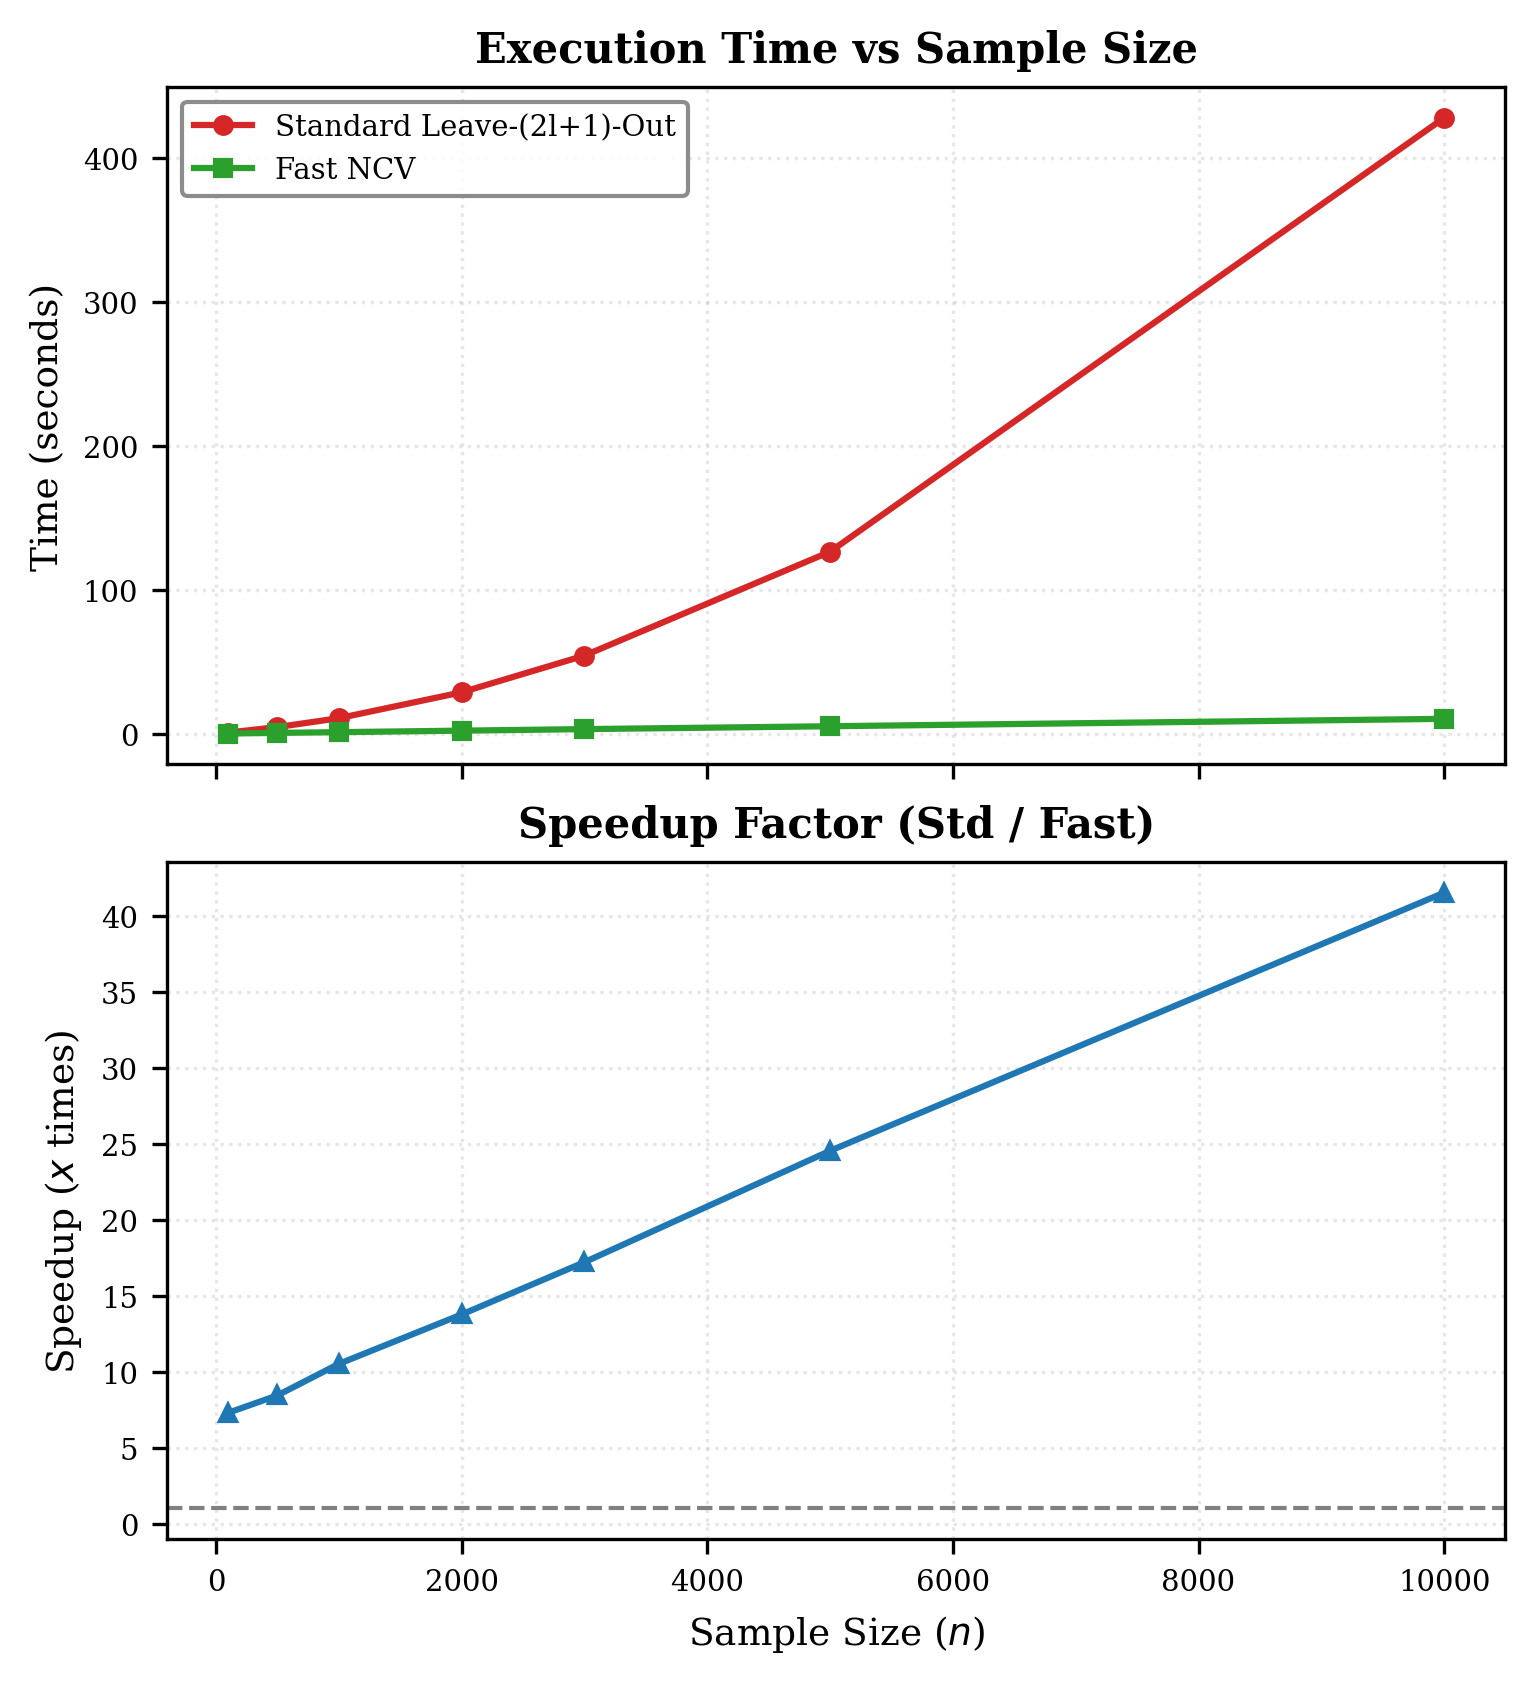

In [10]:
plot_time_comparison(df_results, log_scale=False)